In [1]:
import argparse
import boto3
import pandas as pd
from io import StringIO
import numpy as np
from functools import reduce
from pycytominer import annotate, normalize, feature_select
import pathlib
from sklearn.metrics.pairwise import cosine_similarity
import csv

In [2]:
def compute_image_quality_score(images):
    """
    Compute an image quality score using Z-score normalization for FocusScore and SNR.
    Ensures both features contribute equally to the final score.
    """
    weights = {'FocusScore': 0.6, 'SNR': 0.4}
    
    # Compute SNR per channel
    images['SNR_CL488'] = images['ImageQuality_MeanIntensity_CL488'] / images['ImageQuality_StdIntensity_CL488']
    images['SNR_CL561'] = images['ImageQuality_MeanIntensity_CL561'] / images['ImageQuality_StdIntensity_CL561']
    images['SNR_Hoechst'] = images['ImageQuality_MeanIntensity_Hoechst'] / images['ImageQuality_StdIntensity_Hoechst']
    
    # Compute mean SNR across channels
    images['SNR'] = (images['SNR_CL488'] + images['SNR_CL561'] + images['SNR_Hoechst']) / 3
    
    # Select features for normalization
    features = images[[
        'ImageQuality_FocusScore_CL488', 'ImageQuality_FocusScore_CL561', 'ImageQuality_FocusScore_Hoechst',
        'SNR_CL488', 'SNR_CL561', 'SNR_Hoechst'
    ]]
    
    # Apply Z-score normalization
    scaler = StandardScaler()
    images[['FocusScore_CL488_Z', 'FocusScore_CL561_Z', 'FocusScore_Hoechst_Z',
            'SNR_CL488_Z', 'SNR_CL561_Z', 'SNR_Hoechst_Z']] = scaler.fit_transform(features)
    
    # Compute mean standardized FocusScore and SNR across channels
    images['FocusScore_Z'] = (images['FocusScore_CL488_Z'] + images['FocusScore_CL561_Z'] + images['FocusScore_Hoechst_Z']) / 3
    images['SNR_Z'] = (images['SNR_CL488_Z'] + images['SNR_CL561_Z'] + images['SNR_Hoechst_Z']) / 3
    
    # Compute weighted Quality Score
    images['QualityScore'] = (weights['FocusScore'] * images['FocusScore_Z'] +
                              weights['SNR'] * images['SNR_Z'])
    
    return images[['QualityScore']]

def list_plate_ids(bucket_name, merged_folder):
    """List subfolder names (plate IDs) inside the merged folder in S3."""
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=merged_folder + "/", Delimiter='/')
    
    plate_ids = [prefix['Prefix'].rstrip('/').split('/')[-1] for prefix in response.get('CommonPrefixes', [])]
    return plate_ids
     
def read_csv_from_s3(bucket_name, file_key):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    csv_content = response['Body'].read().decode('utf-8')

    sample = csv_content[:1024]  # Read a small portion of the file
    dialect = csv.Sniffer().sniff(sample, delimiters=";,") 

    return pd.read_csv(StringIO(csv_content), sep=dialect.delimiter)

k = 3
alpha = 2.3538
def double_sigmoid(x):
    return (x/alpha)**k / np.sqrt(1 + (x/alpha)**(2*k))


def process_experiment(input_bucket,output_bucket, output_prefix, plateMap_file_key, merged_folder):
    
    exp = list_plate_ids(input_bucket, merged_folder)
    print(f"Processing plates: {exp}")

    plateMape = read_csv_from_s3(input_bucket, plateMap_file_key)
    plateMape['Compound_name'] = plateMape.apply(
    lambda row: f"NA_{row['compound_code']}" if pd.isna(row['Compound_name']) else row['Compound_name'], axis=1)

    filtered_plateMape =plateMape[["well", "Compound_name", "compound_concentration","timepoint","plate"]]
    filtered_plateMape = filtered_plateMape.rename(columns={
        "plate": "Metadata_Plate",
        "timepoint": "Metadata_Timepoint",
        "Compound_name": "Metadata_compound_code",
        "compound_concentration": "Metadata_compound_concentration",
        "well": "Metadata_Well"
    })
    #filtered_plateMape =plateMape[["Well", "Compound_name", "Dose_ID","Timepoint","Plate_ID"]] for exp2 n 3
    #filtered_plateMape = filtered_plateMape.rename(columns={
    #    "Plate_ID": "Metadata_Plate",
    #    "Timepoint": "Metadata_Timepoint",
    #    "Compound_name": "Metadata_compound_code",
    #    "Dose_ID": "Metadata_compound_concentration",
    #    "Well": "Metadata_Well"
    #})
    filtered_plateMape.Metadata_Timepoint = filtered_plateMape.Metadata_Timepoint + 1

    out_exp_norm = {}

    for plateID in exp:
        nuclei = read_csv_from_s3(input_bucket, f"{merged_folder}/{plateID}/concatenated_nuclei.csv")
        cells = read_csv_from_s3(input_bucket, f"{merged_folder}/{plateID}/concatenated_cells.csv")
        cytoplasm = read_csv_from_s3(input_bucket, f"{merged_folder}/{plateID}/concatenated_cytoplasm.csv")
        images = read_csv_from_s3(input_bucket, f"{merged_folder}/{plateID}/concatenated_image.csv")

        #Dropping duplicated columns, images remais intact to re populate metadata info
        nuclei = nuclei.drop(['ImageNumber', "Metadata_Site"], axis=1)
        cells = cells.drop(['ImageNumber', "Metadata_Site"], axis=1)
        cytoplasm = cytoplasm.drop(['ImageNumber', "Metadata_Site"], axis=1)

        Image = images.drop(['ImageNumber'], axis=1)
        # Identify columns with string values that do not start with 'Metadata'
        Image = Image.drop(columns=[col for col in Image.columns if Image[col].dtype == 'object' and not col.startswith('Metadata')])


        #well level aggreggated, trouble shoout later the pycytomaner function
        nuclei = nuclei.groupby(['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint'], as_index=False).mean()
        cells = cells.groupby(['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint'], as_index=False).mean()
        cytoplasm = cytoplasm.groupby(['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint'], as_index=False).mean()
        Image = Image.groupby(['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint'], as_index=False).mean()

        Image = Image.rename(columns=lambda x: 'Image_' + x if x not in ['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Timepoint'] else x)
        dfs_CP = [cells, nuclei, Image, cytoplasm]
        df_CP_merged = reduce(lambda left, right: pd.merge(left, right, on=['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint'], how='outer'), dfs_CP)

        if plateID =="GCOE24003461":
            df_CP_merged.Metadata_Timepoint = df_CP_merged.Metadata_Timepoint - 22
        #annotation of the plate map and renaming of the plateID if neccessary
        df_CP_merged.Metadata_Plate = plateID
        df_CP_merged_ann = annotate(df_CP_merged, filtered_plateMape, join_on=[["Metadata_Plate", "Metadata_Well", "Metadata_Timepoint"], ["Metadata_Plate", "Metadata_Well", "Metadata_Timepoint"]])

        time_points = df_CP_merged_ann.Metadata_Timepoint.unique()
        output_dict_of_normalized_dfs = {}

        for time_point in time_points:
            time_point_df = df_CP_merged_ann.loc[df_CP_merged_ann.Metadata_Timepoint == time_point]
            features = df_CP_merged_ann.columns[~df_CP_merged_ann.columns.str.contains("Metadata")].to_list()

            normalized_df = normalize(
                profiles=time_point_df,
                features=features,
                samples=f"Metadata_compound_code == 'ZPE' and Metadata_Timepoint == {time_point}",
                method="mad_robustize"
            )
            output_dict_of_normalized_dfs[time_point] = normalized_df

        normalized_CP = pd.concat(output_dict_of_normalized_dfs.values()).reset_index(drop=True)
        out_exp_norm[plateID] = normalized_CP
        print(f"Plate {plateID} finished!")
    
    normalized_exp = pd.concat(out_exp_norm.values()).reset_index(drop=True)

    #Apply double sigmoid trasnfromation to caclulate bioactivity
    all_features_cp = normalized_exp.columns[~normalized_exp.columns.str.contains("Metadata")].to_list()
    normalized_exp[all_features_cp] = normalized_exp[all_features_cp].astype(float)
    normalized_exp[all_features_cp] = normalized_exp[all_features_cp].apply(double_sigmoid)
    normalized_exp.loc[:, all_features_cp] = normalized_exp.loc[:, all_features_cp].abs()

    s3 = boto3.client('s3')
    csv_buffer = StringIO()
    normalized_exp.to_csv(csv_buffer, index=False)
    output_key = f"{output_prefix}/double_sigmoid_CP_features.csv"
    s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
    print(f"Saved to S3: s3://{output_bucket}/{output_key}")

    feature_select_file = pathlib.Path("output_data/normalized_cpfeature_select.csv")
    feature_select_opts = ["variance_threshold", "drop_na_columns", "correlation_threshold", "drop_outliers"]
    features = normalized_exp.columns[~normalized_exp.columns.str.contains("Metadata")].tolist()

    feature_select(
        profiles=normalized_exp,
        features=features,
        samples="all",
        operation=feature_select_opts,
        output_file=feature_select_file,
        output_type="csv"
    )

    normalized_exp_selected = pd.read_csv(feature_select_file)

    csv_buffer = StringIO()
    normalized_exp_selected.to_csv(csv_buffer, index=False)
    output_key = f"{output_prefix}/CP_features_selected.csv"
    s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
    print(f"Saved to S3: s3://{output_bucket}/{output_key}")

    cpfeature_cos=normalized_exp_selected.drop(columns=['Metadata_Plate','Metadata_Well','Metadata_Site'])
    
    averaged_similarities=[]
    similarities=[]

    for (compound_code, timepoint, compound_concentration) in cpfeature_cos[['Metadata_compound_code','Metadata_Timepoint','Metadata_compound_concentration']].drop_duplicates().values: 
        #Filter the data based on the unique combination of metadata values
        group=cpfeature_cos[
            (cpfeature_cos['Metadata_compound_code']==compound_code) &
            (cpfeature_cos['Metadata_Timepoint']==timepoint) &
            (cpfeature_cos['Metadata_compound_concentration']==compound_concentration)
        ]
        
        #Extract the feature columns
        features=group.drop(columns=['Metadata_compound_code','Metadata_Timepoint','Metadata_compound_concentration'])
        features = features.fillna(0)
        #Compute the pairwise cosine similarity within the same metadata group
        pairwise_similarities=cosine_similarity(features)
        
        # Extract the upper triangular part of the similarity matrix, excluding diagonal
        # The diagonal contains similarity of a row with itself, which is always 1 (we exclude it)
        triu_indices = np.triu_indices_from(pairwise_similarities, k=1)
        pairwise_similarities_values = pairwise_similarities[triu_indices]

        # Calculate the average cosine similarity for this subset
        avg_similarity = np.mean(pairwise_similarities_values) if len(pairwise_similarities_values) > 0 else np.nan
    
        # Store the average similarity along with subset information
        averaged_similarities.append({
        'Metadata_compound_code': compound_code,
        'Metadata_Timepoint': timepoint,
        'Metadata_compound_concentration': compound_concentration,
        'average_cosine_similarity': avg_similarity
        })

        similarities.append({
                'Metadata_Compound': compound_code,
                'Metadata_Timepoint': timepoint,
                'Metadata_Condition': compound_concentration,
                'Replicates': group.index, 
                'cosine_similarities': pairwise_similarities_values 
            })

        # Convert the results into a DataFrame
    df_averaged_similarities = pd.DataFrame(averaged_similarities)
    df_similarities = pd.DataFrame(similarities)

    csv_buffer = StringIO()
    df_averaged_similarities.to_csv(csv_buffer, index=False)
    output_key = f"{output_prefix}/CPfeatures__average_cosine_similarity.csv"
    s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
    print(f"Saved to S3: s3://{output_bucket}/{output_key}")

    csv_buffer = StringIO()
    df_similarities.to_csv(csv_buffer, index=False)
    output_key = f"{output_prefix}/CPfeatures_cosine_similarities.csv"
    s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
    print(f"Saved to S3: s3://{output_bucket}/{output_key}")





In [3]:
list_plate_ids("cellprofiler-resuts", "IRIC/CQDM_CTL_Plate_Validation_202501")

['Plate_1', 'Plate_2', 'Segmentation_troubleshooting']

In [9]:
process_experiment(
        input_bucket="cellprofiler-resuts",
        output_bucket="cellprofiler-resuts",
        output_prefix="Exp1_Pycy_Res",
        plateMap_file_key="Merged_CP_exp1/Allmetadata_for_analysis_experiment1_68compounds.csv", 
        merged_folder="Merged_CP_exp1"  #only change to run the exp2 n 3
    )

Processing plates: ['GARP00589082', 'GARP00589083', 'GARP00589084', 'GARP00589085', 'GARP00589086']
Plate GARP00589082 finished!
Plate GARP00589083 finished!
Plate GARP00589084 finished!
Plate GARP00589085 finished!
Plate GARP00589086 finished!
Saved to S3: s3://cellprofiler-resuts/Exp1_Pycy_Res/double_sigmoid_CP_features.csv
Saved to S3: s3://cellprofiler-resuts/Exp1_Pycy_Res/CP_features_selected.csv
Saved to S3: s3://cellprofiler-resuts/Exp1_Pycy_Res/CPfeatures__average_cosine_similarity.csv
Saved to S3: s3://cellprofiler-resuts/Exp1_Pycy_Res/CPfeatures_cosine_similarities.csv


In [6]:
bucket_name="cellprofiler-resuts"
base_folder_path='IRIC/CQDM_CTL_Plate_Validation_202501/Plate_1'
num_timepoints=9
output_bucket="cellprofiler-resuts"
output_prefix="IRIC_Merged_CTL_Val"

In [ ]:
nuclei = read_csv_from_s3("cellprofiler-resuts", "Merged_CQDM_CTL_Val/concatenated_nuclei.csv")

In [ ]:

s3 = boto3.client('s3')

datasets = {"nuclei": [], "cytoplasm": [], "image": [], "cells": []}
paginator = s3.get_paginator('list_objects_v2')

# Iterate through all pages of results
for page in paginator.paginate(Bucket=bucket_name, Prefix=base_folder_path):
    for obj in page.get('Contents', []):
        key = obj['Key']

        # Extract timepoint from folder structure
        for file_type in datasets.keys():
            if f"{file_type.capitalize()}.csv" in key:
                try:
                    response = s3.get_object(Bucket=bucket_name, Key=key)
                    csv_stream = response['Body'].read().decode('utf-8')

                    # Read CSV in chunks
                    chunk_list = []
                    for chunk in pd.read_csv(StringIO(csv_stream), chunksize=100000):
                        chunk["Metadata_Timepoint"] = key.split("/")[-2]  # Extract timepoint
                        chunk_list.append(chunk)

                    # Store processed chunks
                    datasets[file_type].append(pd.concat(chunk_list, ignore_index=True))

                except Exception as e:
                    print(f"Error processing {key}: {e}")

# Concatenate DataFrames
for file_type in datasets.keys():
    datasets[file_type] = pd.concat(datasets[file_type], ignore_index=True) if datasets[file_type] else pd.DataFrame()

# Merge metadata from Image table
if not datasets["image"].empty:
    metadata_columns = ['ImageNumber', 'Metadata_Plate', 'Metadata_Site', 'Metadata_Well']
    metadata_df = datasets["image"][metadata_columns]

    for file_type in ["nuclei", "cytoplasm", "cells"]:
        if not datasets[file_type].empty and 'ImageNumber' in datasets[file_type]:
            datasets[file_type] = datasets[file_type].merge(metadata_df, on='ImageNumber', how='left')

# Save to disk to free memory
for file_type, df in datasets.items():
    if not df.empty:
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        output_key = f"{output_prefix}/concatenated_{file_type}.csv"
        
        s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
        print(f"Saved to S3: s3://{output_bucket}/{output_key}")


ValueError: invalid literal for int() with base 10: '72h_2'

In [23]:

plateMape = read_csv_from_s3("cellprofiler-resuts", "Merged_CP_exp1/Allmetadata_for_analysis_experiment1_68compounds.csv")
plateMape['Compound_name'] = plateMape.apply(
lambda row: f"NA_{row['compound_code']}" if pd.isna(row['Compound_name']) else row['Compound_name'], axis=1)

filtered_plateMape =plateMape[["well", "Compound_name", "compound_concentration","timepoint","plate"]]
filtered_plateMape = filtered_plateMape.rename(columns={
    "plate": "Metadata_Plate",
    "timepoint": "Metadata_Timepoint",
    "Compound_name": "Metadata_compound_code",
    "compound_concentration": "Metadata_compound_concentration",
    "well": "Metadata_Well"
})
#filtered_plateMape =plateMape[["Well", "Compound_name", "Dose_ID","Timepoint","Plate_ID"]] for exp2 n 3
#filtered_plateMape = filtered_plateMape.rename(columns={
#    "Plate_ID": "Metadata_Plate",
#    "Timepoint": "Metadata_Timepoint",
#    "Compound_name": "Metadata_compound_code",
#    "Dose_ID": "Metadata_compound_concentration",
#    "Well": "Metadata_Well"
#})
filtered_plateMape.Metadata_Timepoint = filtered_plateMape.Metadata_Timepoint + 1


nuclei = read_csv_from_s3("clientsdata", "Pfizer_livecellpainting_64compounds/68_compounds_1stexperiment_springs_outputs/well_aggregated_features/Springs_cellprofilerlike_features/nuclei_features.csv")
cells = read_csv_from_s3("clientsdata", "Pfizer_livecellpainting_64compounds/68_compounds_1stexperiment_springs_outputs/well_aggregated_features/Springs_cellprofilerlike_features/cell_features_2.csv")
cytoplasm = read_csv_from_s3("clientsdata", "Pfizer_livecellpainting_64compounds/68_compounds_1stexperiment_springs_outputs/well_aggregated_features/Springs_cellprofilerlike_features/cellcount_features.csv")
images = read_csv_from_s3("clientsdata", "Pfizer_livecellpainting_64compounds/68_compounds_1stexperiment_springs_outputs/well_aggregated_features/Springs_cellprofilerlike_features/image_features.csv")

#Dropping duplicated columns, images remais intact to re populate metadata info
nuclei = nuclei.drop(['compound_concentration','palette_number','z_layer','compound_code'], axis=1)
cells = cells.drop(['compound_concentration','palette_number','z_layer','compound_code'], axis=1)
cytoplasm = cytoplasm.drop(['compound_concentration','palette_number','z_layer','compound_code'], axis=1)

#Image = images.drop(['ImageNumber'], axis=1)
# Identify columns with string values that do not start with 'Metadata'
#Image = Image.drop(columns=[col for col in Image.columns if Image[col].dtype == 'object' and not col.startswith('Metadata')])


#well level aggreggated, trouble shoout later the pycytomaner function
#Image = Image.rename(columns=lambda x: 'Image_' + x if x not in ['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Timepoint'] else x)
dfs_CP = [cells, nuclei, images, cytoplasm]
df_CP_merged = reduce(lambda left, right: pd.merge(left, right, on=['plate','well','timepoint'], how='outer'), dfs_CP)
df_CP_merged=df_CP_merged.rename(columns={"plate":"Metadata_plate_ID","well":"Metadata_Well","timepoint":"Metadata_Timepoint",
                                    "compound_concentration":"Metadata_compound_concentration","compound_code":"Metadata_compound_code",
                                    "palette_number":"Metadata_palette_number","z_layer":"Metadata_z_layer"})

time_points = df_CP_merged.Metadata_Timepoint.unique()
output_dict_of_normalized_dfs = {}

out_exp_norm={}

for plateID in df_CP_merged.Metadata_plate_ID.unique():
    df=df_CP_merged.loc[df_CP_merged["Metadata_plate_ID"]==plateID]
    for time_point in time_points:
        time_point_df = df.loc[df.Metadata_Timepoint == time_point]
        features = df.columns[~df.columns.str.contains("Metadata")].to_list()
    
        normalized_df = normalize(
            profiles=time_point_df,
            features=features,
            samples=f"Metadata_compound_code == 'ZPE' and Metadata_Timepoint == {time_point}",
            method="mad_robustize"
        )
        output_dict_of_normalized_dfs[time_point] = normalized_df
    
    normalized_CP = pd.concat(output_dict_of_normalized_dfs.values()).reset_index(drop=True)
    out_exp_norm[plateID] = normalized_CP
    print(f"Plate {plateID} finished!")

normalized_exp = pd.concat(out_exp_norm.values()).reset_index(drop=True)

#Apply double sigmoid trasnfromation to caclulate bioactivity
all_features_cp = normalized_exp.columns[~normalized_exp.columns.str.contains("Metadata")].to_list()
normalized_exp[all_features_cp] = normalized_exp[all_features_cp].astype(float)
normalized_exp[all_features_cp] = normalized_exp[all_features_cp].apply(double_sigmoid)
normalized_exp.loc[:, all_features_cp] = normalized_exp.loc[:, all_features_cp].abs()


Plate GARP00589082 finished!
Plate GARP00589083 finished!
Plate GARP00589084 finished!
Plate GARP00589085 finished!
Plate GARP00589086 finished!


In [28]:
s3 = boto3.client('s3')
csv_buffer = StringIO()
normalized_exp.to_csv(csv_buffer, index=False)
output_key = "Exp1_Pycy_Res/STRING_double_sigmoid_CP_features_.csv"
s3.put_object(Bucket="cellprofiler-resuts", Key=output_key, Body=csv_buffer.getvalue())


NameError: name 'output_bucket' is not defined

In [21]:
normalized_exp=read_csv_from_s3("cellprofiler-resuts", "Exp1_Pycy_Res/double_sigmoid_CP_features.csv")


In [65]:

feature_select_file = pathlib.Path("output_data/normalized_cpfeature_select.csv")
feature_select_opts = ["variance_threshold", "drop_na_columns", "correlation_threshold", "drop_outliers"]
features = normalized_exp.columns[~normalized_exp.columns.str.contains("Metadata")].tolist()

feature_select(
    profiles=normalized_exp,
    features=features,
    samples="all",
    na_cutoff=0.038,
    corr_threshold=0.90,
    operation=feature_select_opts,
    output_file=feature_select_file,
    output_type="csv"
)



In [66]:
sig= pd.read_csv(feature_select_file)

In [67]:
sig

,Metadata_Well,Metadata_compound_code,Metadata_compound_concentration,Metadata_Timepoint,Metadata_Plate,Metadata_Site,Image_Count_Cells,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02MeasureImageQuality,Image_ExecutionTime_03IdentifyPrimaryObjects,...,Image_Texture_SumEntropy_CL561_3_02_256,Image_Texture_SumVariance_CL488_20_01_256,Image_Texture_SumVariance_CL561_10_00_256,Image_Texture_SumVariance_Hoechst_10_02_256,Image_Threshold_OrigThreshold_Cells,Image_Threshold_OrigThreshold_Nuclei,Image_Threshold_SumOfEntropies_Cells,Image_Threshold_SumOfEntropies_Nuclei,Image_Threshold_WeightedVariance_Cells,Image_Threshold_WeightedVariance_Nuclei
0,A01,Colchicine,1,1,GARP00589082,2.5,0.300635,0.088222,0.031522,9.787354e-01,...,0.057605,0.072645,0.778020,0.005082,0.225554,0.571539,0.006588,0.101241,0.017124,0.338542
1,A02,Colchicine,2,1,GARP00589082,2.5,0.953602,0.006972,0.957467,6.708338e-01,...,0.085900,0.941478,0.194237,0.876637,0.088576,0.835011,0.242203,0.027131,0.650556,0.121700
2,A03,Colchicine,3,1,GARP00589082,2.5,0.100456,0.055688,0.957467,5.832741e-01,...,0.000067,0.393908,0.050681,0.144436,0.130245,0.118056,0.081432,0.000477,0.000059,0.000828
3,A04,Colchicine,4,1,GARP00589082,2.5,0.929578,0.536240,0.926970,1.849900e-01,...,0.153413,0.080301,0.117489,0.437202,0.111948,0.295229,0.139433,0.024922,0.000014,0.095119
4,A05,Colchicine,5,1,GARP00589082,2.5,0.033484,0.000258,0.049522,4.590830e-02,...,0.000011,0.005726,0.060659,0.016392,0.055295,0.003530,0.145076,0.177915,0.007226,0.036563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35855,P02,Binimetinib,2,22,GARP00589086,2.5,0.536240,0.088222,0.000215,7.483290e-05,...,0.998201,0.513161,0.991652,0.975403,0.017361,0.997131,0.000201,0.000079,0.562288,0.987156
35856,P03,Binimetinib,3,22,GARP00589086,2.5,0.536240,0.000258,0.420255,7.483290e-05,...,0.997973,0.999582,0.017771,0.821204,0.152205,0.968946,0.048492,0.235423,0.861757,0.094866
35857,P04,Binimetinib,4,22,GARP00589086,2.5,0.184990,0.021006,0.007458,2.565923e-02,...,0.991791,0.127332,0.000038,0.840620,0.001702,0.933734,0.003643,0.616719,0.079065,0.007495
35858,P05,Binimetinib,5,22,GARP00589086,2.5,0.536240,0.000077,0.010108,5.986632e-07,...,0.880703,0.137297,0.999646,0.775999,0.657420,0.845094,0.015873,0.428948,0.068638,0.002466


In [ ]:
output_prefix="Exp1_Pycy_Res"
output_bucket="cellprofiler-resuts"

csv_buffer = StringIO()
normalized_exp_selected.to_csv(csv_buffer, index=False)
output_key = f"{output_prefix}/CP_features_selected_stringent.csv"
s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
print(f"Saved to S3: s3://{output_bucket}/{output_key}")

cpfeature_cos=normalized_exp_selected.drop(columns=['Metadata_Plate','Metadata_Well','Metadata_Site'])

averaged_similarities=[]
similarities=[]

for (compound_code, timepoint, compound_concentration) in cpfeature_cos[['Metadata_compound_code','Metadata_Timepoint','Metadata_compound_concentration']].drop_duplicates().values: 
    #Filter the data based on the unique combination of metadata values
    group=cpfeature_cos[
        (cpfeature_cos['Metadata_compound_code']==compound_code) &
        (cpfeature_cos['Metadata_Timepoint']==timepoint) &
        (cpfeature_cos['Metadata_compound_concentration']==compound_concentration)
    ]
    
    #Extract the feature columns
    features=group.drop(columns=['Metadata_compound_code','Metadata_Timepoint','Metadata_compound_concentration'])
    features = features.fillna(0)
    #Compute the pairwise cosine similarity within the same metadata group
    pairwise_similarities=cosine_similarity(features)
    
    # Extract the upper triangular part of the similarity matrix, excluding diagonal
    # The diagonal contains similarity of a row with itself, which is always 1 (we exclude it)
    triu_indices = np.triu_indices_from(pairwise_similarities, k=1)
    pairwise_similarities_values = pairwise_similarities[triu_indices]

    # Calculate the average cosine similarity for this subset
    avg_similarity = np.mean(pairwise_similarities_values) if len(pairwise_similarities_values) > 0 else np.nan

    # Store the average similarity along with subset information
    averaged_similarities.append({
    'Metadata_compound_code': compound_code,
    'Metadata_Timepoint': timepoint,
    'Metadata_compound_concentration': compound_concentration,
    'average_cosine_similarity': avg_similarity
    })

    similarities.append({
            'Metadata_Compound': compound_code,
            'Metadata_Timepoint': timepoint,
            'Metadata_Condition': compound_concentration,
            'Replicates': group.index, 
            'cosine_similarities': pairwise_similarities_values 
        })

    # Convert the results into a DataFrame
df_averaged_similarities = pd.DataFrame(averaged_similarities)
df_similarities = pd.DataFrame(similarities)

csv_buffer = StringIO()
df_averaged_similarities.to_csv(csv_buffer, index=False)
output_key = f"{output_prefix}/CPfeatures__average_cosine_similarity.csv"
s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
print(f"Saved to S3: s3://{output_bucket}/{output_key}")

csv_buffer = StringIO()
df_similarities.to_csv(csv_buffer, index=False)
output_key = f"{output_prefix}/CPfeatures_cosine_similarities.csv"
s3.put_object(Bucket=output_bucket, Key=output_key, Body=csv_buffer.getvalue())
print(f"Saved to S3: s3://{output_bucket}/{output_key}")

0.037037037037037035


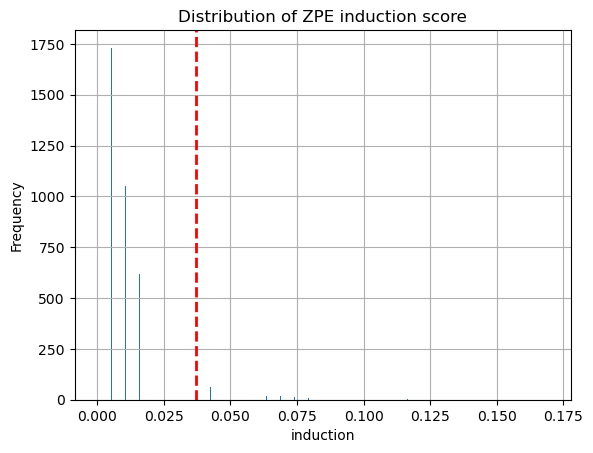

In [68]:
import matplotlib.pyplot as plt
non_metadata_cols = [col for col in sig.columns if not col.startswith("Metadata_")]

# Compute induction score
sig['induction'] = (sig[non_metadata_cols] > 0.95).sum(axis=1) / len(non_metadata_cols)
sig_ind = sig[['Metadata_Plate', 'Metadata_Well', 'Metadata_Timepoint', 
               'Metadata_compound_code', 'Metadata_compound_concentration', 'induction']]

ind_zpe = sig_ind[sig_ind['Metadata_compound_code'] == "ZPE"]

# Compute 95% threshold
bioactive_threshold = np.quantile(ind_zpe['induction'], 0.95)
print(bioactive_threshold)
ind_zpe.induction.hist(bins=1000)
plt.xlabel('induction')
plt.ylabel('Frequency')
plt.axvline(x=bioactive_threshold, color="red", linestyle='dashed', linewidth=2, label=f'Threshold {bioactive_threshold}')
plt.title("Distribution of ZPE induction score")
plt.legend
#plt.yscale('log')  # Log scale to better see outliers
plt.show()

Bioactivity proportions:
 Metadata_Timepoint  1   2   3   4   5   6   7   8   9   10  ...  13  14  15  \
1                   34  44  48  49  50  52  50  54  51  50  ...  49  50  51   
0                   33  23  19  18  17  15  17  13  16  17  ...  18  17  16   

Metadata_Timepoint  16  17  18  19  20  21  22  
1                   52  54  55  54  54  55  54  
0                   15  13  12  13  13  12  13  

[2 rows x 22 columns]


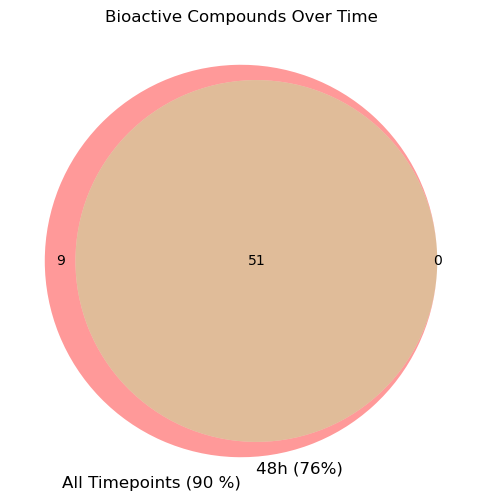

In [71]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

ind_mean = (
    sig_ind[sig_ind['Metadata_compound_code'] != "ZPE"]
    .groupby(['Metadata_Timepoint', 'Metadata_compound_code', 'Metadata_compound_concentration'])
    .agg(induction_mean=('induction', 'mean'))
    .reset_index()
)
wide = ind_mean.pivot(index=['Metadata_Timepoint', 'Metadata_compound_code'], 
                       columns='Metadata_compound_concentration', 
                       values='induction_mean').reset_index()
wide['bioactivity'] = (wide.iloc[:, 2:] >= bioactive_threshold).any(axis=1).astype(int)
wide_tp = wide.pivot(index='Metadata_compound_code', 
                      columns='Metadata_Timepoint', 
                      values='bioactivity').reset_index()

bioactivity_counts = wide_tp.iloc[:, 1:].apply(pd.Series.value_counts).fillna(0)
print("Bioactivity proportions:\n", bioactivity_counts)

wide_tp['Bioactive'] = (wide_tp.iloc[:, 1:] > 0).any(axis=1).astype(int)

alltp_induction = wide_tp.loc[wide_tp['Bioactive'] == 1, 'Metadata_compound_code']
tp48_induction = wide_tp.loc[wide_tp[15] == 1, 'Metadata_compound_code'] 

# Venn diagram
venn_sets = {
    "CL_alltp": set(alltp_induction),
    "CL_48htp": set(tp48_induction)
}

plt.figure(figsize=(6, 6))
venn2([venn_sets["CL_alltp"], venn_sets["CL_48htp"]], set_labels=('All Timepoints (90 %)', '48h (76%)'))
plt.title("Bioactive Compounds Over Time")
plt.show()


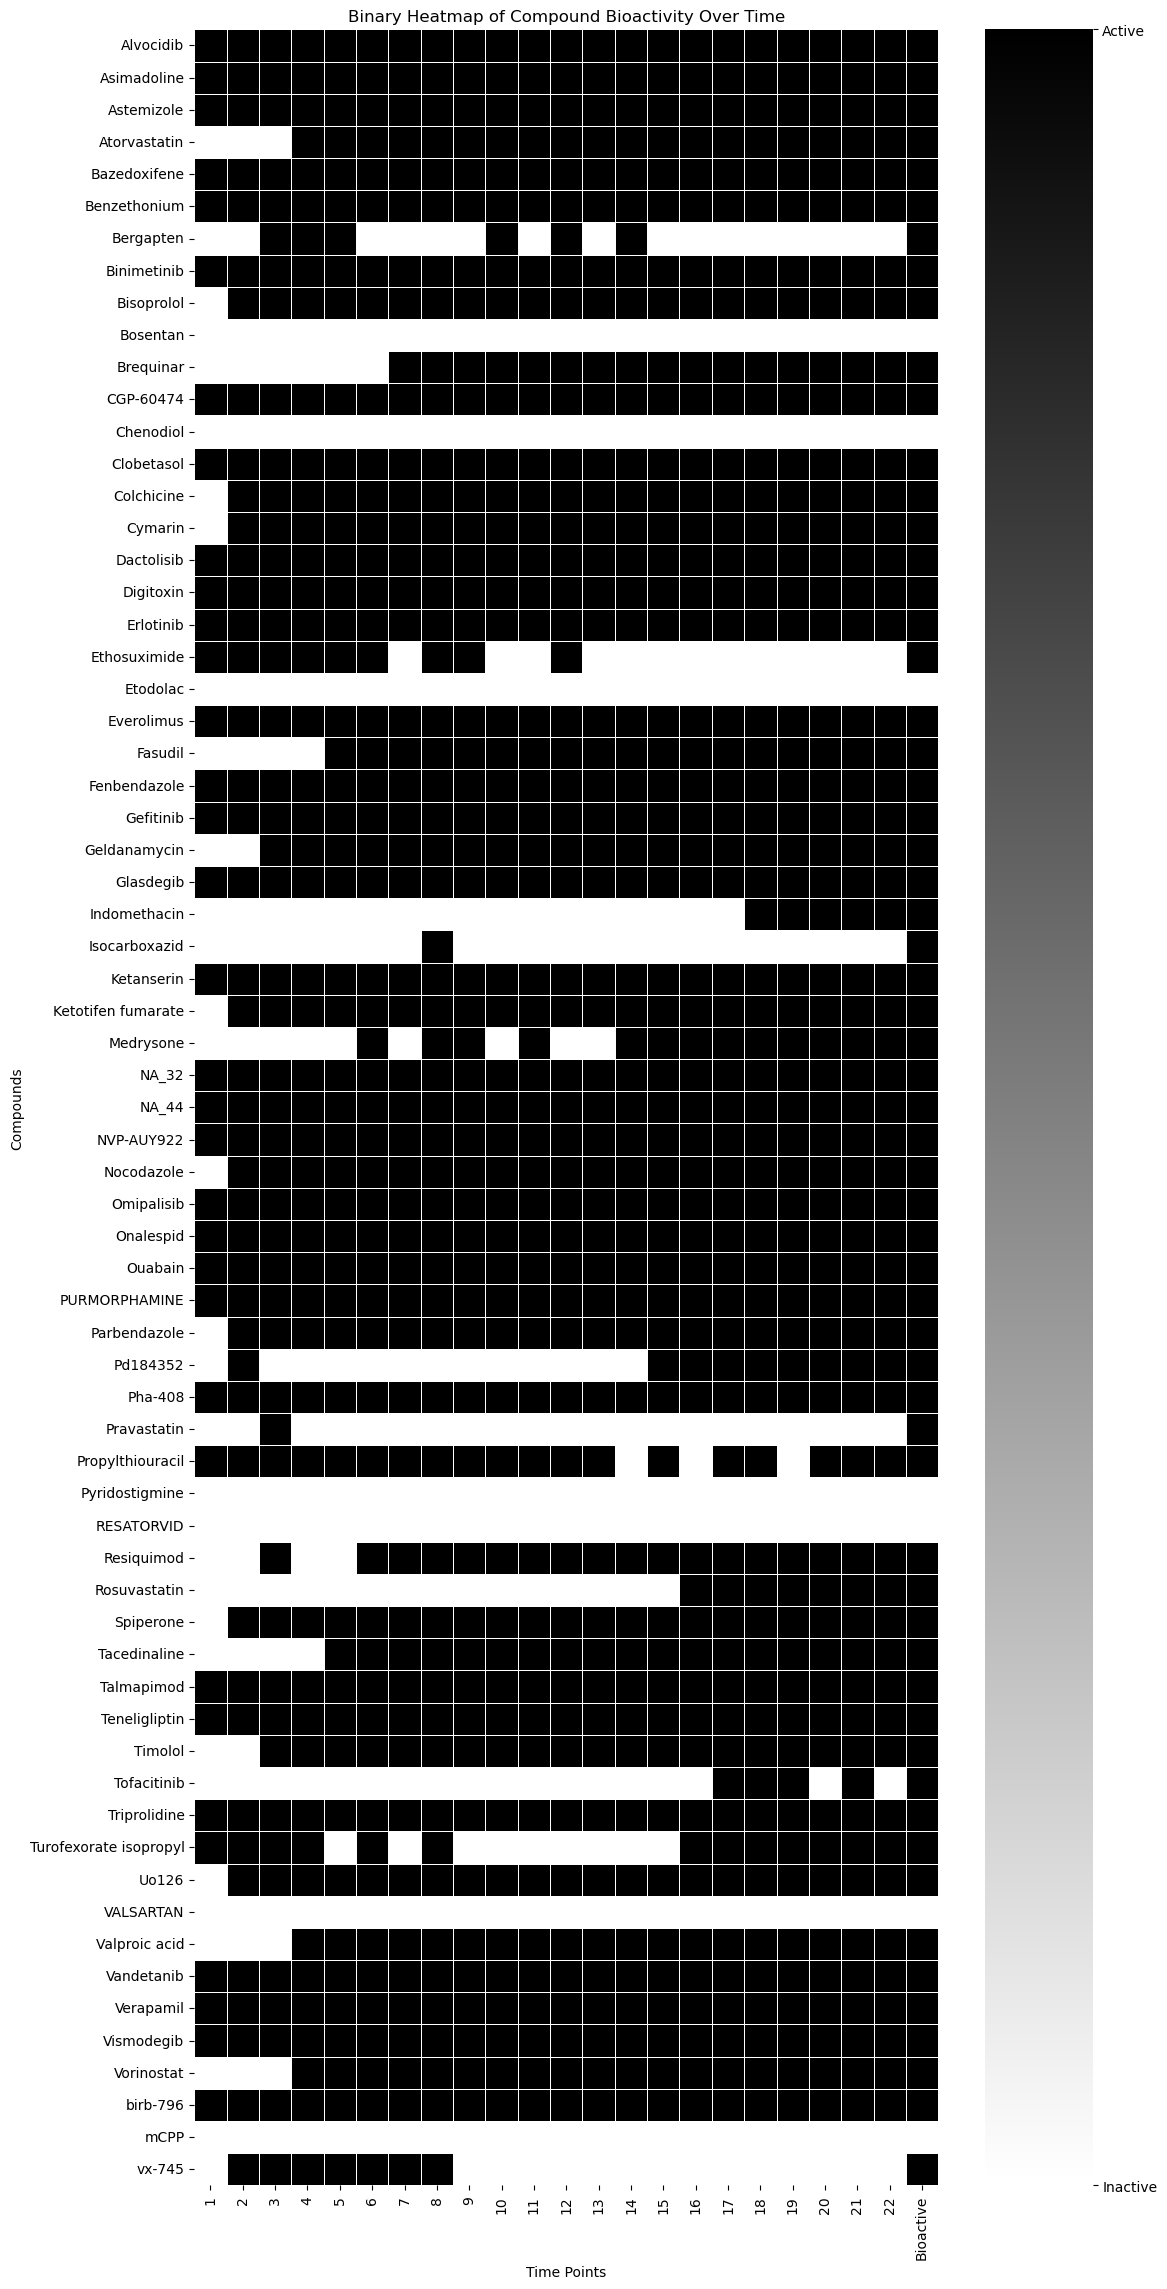

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data (assuming it's a CSV file)
#wide_tp = wide_tp.drop(columns=["Metadata_compound_code"]) # Convert all to numeric, setting errors to NaN if any
wide_tp.set_index("Metadata_compound_code", inplace=True)
#wide_tp = wide_tp.sort_index() 

plt.figure(figsize=(12, 28))
ax = sns.heatmap(wide_tp, cmap="gray_r", linewidths=0.5, cbar_kws={"ticks": [0, 1]})

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(["Inactive", "Active"])

# Move y-axis to the right and invert x-axis # Y-axis on the right
#plt.gca().invert_xaxis()  # Time points from right to left

#ax.yaxis.set_label_position("right")
#ax.yaxis.set_ticks_position("right")

# Make the y-axis labels horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
#colorbar.ax.set_position([0.05, 0.1, 0.02, 0.8]) 

plt.xlabel("Time Points")
plt.ylabel("Compounds")
plt.title("Binary Heatmap of Compound Bioactivity Over Time")
plt.show()